<a href="https://colab.research.google.com/github/sbbwoy/ESAA/blob/main/220516_Recommendation_with_Amazon_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ...

In [17]:
import pandas as pd
import numpy as np

In [2]:
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset
    
    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)] 
        val_pct : (int, float), validation set percentage 
        seed : seed value for RandomState
        
    Returns:
        list of indexes 
    """
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [ ]:
!pip install fastai

In [6]:
import fastai 

In [ ]:
! pip install fastai==0.7
! pip install torch==0.3.1
! pip install torchvision==0.2.2
! pip install Pillow==6.2.2
! pip install pyknon
! pip install torchtext==0.2.3

In [41]:
!pip -upgrade


Usage:   
  pip3 <command> [options]

no such option: -u


In [38]:
!pip install PyTorch

  ERROR: Failed building wheel for PyTorch
  Running setup.py clean for PyTorch
Failed to build PyTorch
    Running setup.py install for PyTorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-r6hstmeb/pytorch_4b1e1f28483d434f94a61b33cfcd8e7a/setup.py'"'"'; __file__='"'"'/tmp/pip-install-r6hstmeb/pytorch_4b1e1f28483d434f94a61b33cfcd8e7a/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-8pj3v_oh/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/PyTorch Check the logs for full command output.


In [40]:
!git clone https://github.com/fastai/fastai
!pip install -e "fastai[dev]"

Cloning into 'fastai'...
remote: Enumerating objects: 17692, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 17692 (delta 81), reused 98 (delta 70), pack-reused 17566
Receiving objects: 100% (17692/17692), 756.62 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (13972/13972), done.
Obtaining file:///content/fastai
     |████████████████████████████████| 59 kB 2.7 MB/s 
     |████████████████████████████████| 21.0 MB 1.8 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 584 kB 41.7 MB/s 
     |████████████████████████████████| 259 kB 40.6 MB/s 
     |████████████████████████████████| 4.2 MB 32.2 MB/s 
     |████████████████████████████████| 1.2 MB 46.9 MB/s 
     |████████████████████████████████| 2.0 MB 53.6 MB/s 
     |████████████████████████████████| 446 kB 53.4 MB/s 
     |████████████████████████████████| 1.4 MB 43.7 MB/s 
     |████████████████████████████████| 

In [24]:
from fastai.collab import *

In [21]:
from torch import nn

In [43]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.05,0.05)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users, items):
        um = self.u(users)* self.i(items)
        res = um.sum(1) + self.ub(users).squeeze() + self.ib(items).squeeze()
        return F.sigmoid(res) * (self.max_score-self.min_score) + self.min_score

class CollabFilterLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss

class CollabFilterModel(BasicModel):
    def get_layer_groups(self): return self.model

NameError: ignored

In [15]:
class CollabFilterDataset(Dataset):
    def __init__(self, path, user_col, item_col, ratings):
        self.ratings,self.path = ratings.values.astype(np.float32),path
        self.n = len(ratings)
        (self.users,self.user2idx,self.user_col,self.n_users) = self.proc_col(user_col)
        (self.items,self.item2idx,self.item_col,self.n_items) = self.proc_col(item_col)
        self.min_score,self.max_score = min(ratings),max(ratings)
        self.cols = [self.user_col,self.item_col,self.ratings]

    @classmethod
    def from_data_frame(cls, path, df, user_name, item_name, rating_name):
        return cls(path, df[user_name], df[item_name], df[rating_name])

    @classmethod
    def from_csv(cls, path, csv, user_name, item_name, rating_name):
        df = pd.read_csv(os.path.join(path,csv))
        return cls.from_data_frame(path, df, user_name, item_name, rating_name)

    def proc_col(self,col):
        uniq = col.unique()
        name2idx = {o:i for i,o in enumerate(uniq)}
        return (uniq, name2idx, np.array([name2idx[x] for x in col]), len(uniq))

    def __len__(self): return self.n
    def __getitem__(self, idx): return [o[idx] for o in self.cols]

    def get_data(self, val_idxs, bs):
        val, trn = zip(*split_by_idx(val_idxs, *self.cols))
        return ColumnarModelData(self.path, PassthruDataset(*trn), PassthruDataset(*val), bs)

    def get_model(self, n_factors):
        model = EmbeddingDotBias(n_factors, self.n_users, self.n_items, self.min_score, self.max_score)
        return CollabFilterModel(to_gpu(model))

    def get_learner(self, n_factors, val_idxs, bs, **kwargs):
        return CollabFilterLearner(self.get_data(val_idxs, bs), self.get_model(n_factors), **kwargs)
        

In [42]:
ratings = pd.read_csv('ratings.csv') # loading data from csv

path = '/content'

val_indx = get_cv_idxs(len(ratings))  # index for validation set
wd = 2e-4 # weight decay
n_factors = 50 # n_factors - dimension of embedding matrix (D)

# data loader
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')

# learner initializes model object
learn = cf.get_learner(n_factors, val_indx, bs=64, opt_fn=optim.Adam)

# fitting model with 1e-2 learning rate, 2 epochs, 
# (1 cycle length and 2 cycle multiple for learning rate scheduling)
learn.fit(1e-2,2, wds = wd, cycle_len=1, cycle_mult=2)

NameError: ignored

#Amazon reviews를 이용한 추천 시스템 실습

In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

##데이터 불러오기

In [60]:
electronics_data = pd.read_csv("/content/ratings_Electronics.csv",names=['userId', 'productId','Rating','timestamp'])
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [61]:
electronics_data.shape

(7824482, 4)

In [62]:
electronics_data = electronics_data.iloc[:1048576, 0:]
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [63]:
electronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [64]:
print('max of rating: %d' %(electronics_data.Rating.max()))
print('min of rating: %d' %(electronics_data.Rating.min()))

max of rating: 5
min of rating: 1


##결측치 찾기

In [65]:
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


##EDA

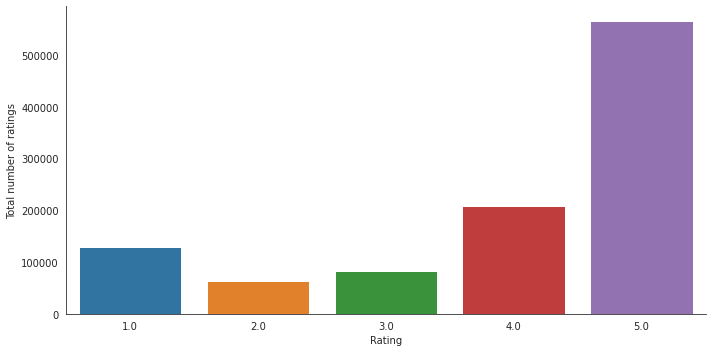

In [66]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data  = electronics_data, aspect = 2.0, kind = 'count')
    g.set_ylabels("Total number of ratings")

In [67]:
print("Total data")
print("-"*50)
print("\nTotal num of ratings :", electronics_data.shape[0])
print("Total num of Users :", len(np.unique(electronics_data.userId)))
print("Total num of products: ", len(np.unique(electronics_data.productId)))

Total data
--------------------------------------------------

Total num of ratings : 1048576
Total num of Users : 786330
Total num of products:  61894


In [68]:
electronics_data.drop(['timestamp'],axis = 1, inplace = True)
electronics_data.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


##Ratings 분석

In [69]:
num_of_rated_products_per_user = electronics_data.groupby(by = 'userId')['Rating'].count().sort_values(ascending=False)
num_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [70]:
num_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [71]:
quantiles = num_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
quantiles

0.00      1
0.01      1
0.02      1
0.03      1
0.04      1
       ... 
0.96      3
0.97      4
0.98      4
0.99      6
1.00    412
Name: Rating, Length: 101, dtype: int64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

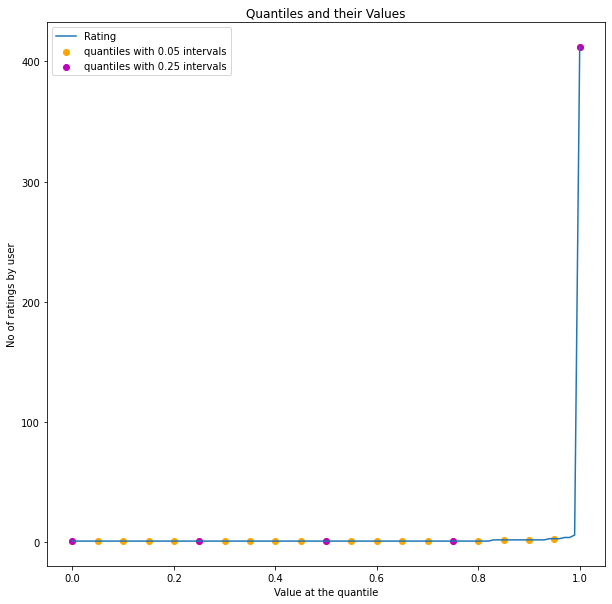

In [72]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [73]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(num_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



## popularity 기반 추천

In [74]:
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)
new_df.head()

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [75]:
new_df.shape

(677947, 3)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

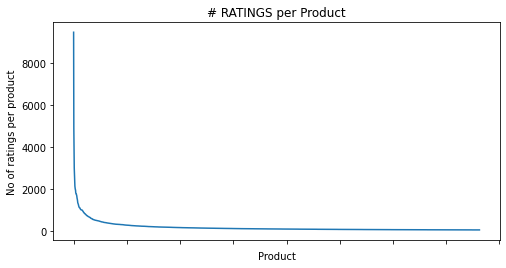

In [78]:
num_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(num_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [79]:
new_df.groupby('productId')['Rating'].mean().head()# 상품별 평점

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [80]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head() #평점기준 내림차순

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [81]:
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head() #평가수 기준 내림차순
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())
ratings_mean_count.head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

,Rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


In [82]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [83]:
ratings_mean_count['rating_counts'].max()

9487

<Figure size 432x432 with 0 Axes>

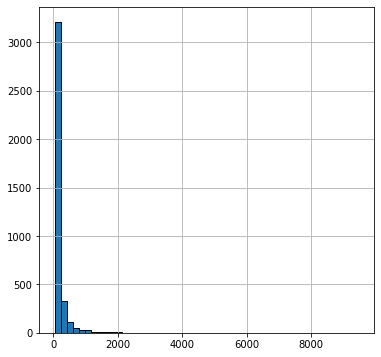

In [84]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

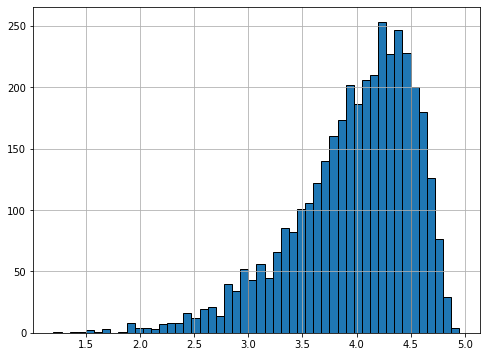

In [85]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

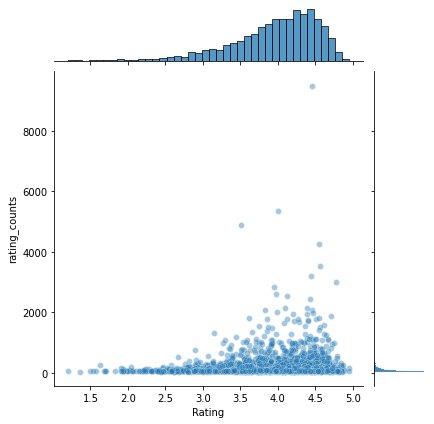

In [86]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

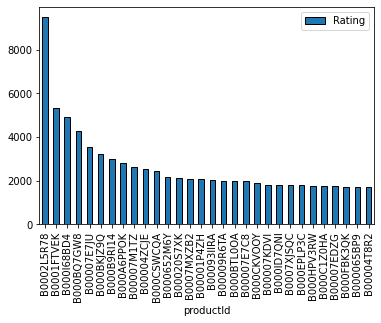

In [87]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values("Rating", ascending=False)
most_popular.head(30).plot(kind = "bar")